## Bandit Feedback

In the previous notebook we built a purely organic model of user behaviour and used next item prediction to build a recommender system.

We then evaluated how that recommender system performed using IPS.

We also simmulated an AB test.

It is important to recognise that these methods used next item prediction as a proxy for recommendation quality.  Only when we used IPS or an AB test were we actually checking if these recommendations performed well against actual clicks on actual recommendations.

The course now moves to the topic of how to train on actual recommender system logs (rather than a dataset such as movielens that only gives information about user preferences but no measure about if recommendations are successful or otherwise).

The course closely follows the material in this short paper: https://arxiv.org/pdf/1904.10799.pdf


Bandit feedback raises several complications:

1.  Usually we deliver good recommendations if we can, this means that the data is concentrated around good recommendations (as we understand them to be).

2.  There are multiple ways to train on bandit feedback including pure likelihood or Bayesian approaches or approaches that use a counterfactual risk minimisation method that uses the inverse propensity score.  In this notebook we will consider the Likelihood approach.

3.  The support of Bandit feedback is different.  For our click model we have a Bernoulli model for every (counterfactual) action.  In contrast the organic data is a draw from a categorical.  From a practical perspective if there are P products then the bandit data has P parameters between 0 and 1 for a probability of a click where organic data has P parameters that sum to one for the probability of the next item.

4.  Click through rates are usually low and the click through rates for some actions are often very similar therefore we must estimate very low treatment effects.



## Likelihood based models

This notebook will outline the likelihood based approach to training on Bandit feedback.

Although before proceeding we will study the output of the simmulator in a little more detail.

In [1]:
import gym, reco_gym
from copy import deepcopy
from reco_gym import env_1_args
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 3]

ABTestNumberOfUsers=500
NumberOfProducts=10
NumberOfSamples = 20
env_1_args['phi_var']=0.0
env_1_args['number_of_flips']=0
env_1_args['sigma_mu_organic'] = 0.0
env_1_args['sigma_omega']=0
env_1_args['random_seed'] = 42
env_1_args['num_products'] = NumberOfProducts
env_1_args['K'] = 5
env_1_args['number_of_flips'] = 4

env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

In [2]:
from agents import OrganicUserEventCounterAgent, organic_user_count_args
from reco_gym import Configuration

organic_counter_agent = OrganicUserEventCounterAgent(Configuration({
            **organic_user_count_args,
            **env_1_args,
            'select_randomly': True,
        }))

In [3]:
data = deepcopy(env).generate_logs(ABTestNumberOfUsers)
#data = deepcopy(env).generate_logs(ABTestNumberOfUsers,
#                                   agent = organic_counter_agent)

In [4]:
data[:NumberOfSamples]

,t,u,z,v,a,c,ps,ps-a
0,0,0,organic,0.0,NaN,NaN,NaN,None
1,1,0,bandit,NaN,3.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
2,2,0,bandit,NaN,4.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
3,3,0,bandit,NaN,5.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
4,0,1,organic,1.0,NaN,NaN,NaN,None
5,1,1,bandit,NaN,2.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
6,2,1,bandit,NaN,8.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
7,3,1,bandit,NaN,4.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
8,4,1,organic,6.0,NaN,NaN,NaN,None
9,5,1,organic,6.0,NaN,NaN,NaN,None


Here is the data the following columns are present:
* **`t`**—_`Time`_. Currently, _`Time`_ reflects the order of _`Events`_ but it does **not** represent the notion of the time in a physical sense.
* **`u`**—_`User`_.
* **`z`**—_`Event Type`_. There are two types of _`Events`_: _Organic_ and _Bandit_.
* **`v`**—_`View`_. The column shows which _`Product`_ was shown to a _`User`_ in an _Organic_ _`Event`_.
* **`a`**—_`Action`_. Currently, _`Action`_ is a _`Product`_ that was provided to a _`User`_ during a _Bandit_ _`Event`_.
* **`c`**—_`Click`_. This is a _Reward_ for an _`Action`_ provided by the _`Agent`_.
* **`ps`**—Probability of selecting a particular _`Action`_.

**Note #1:** _`Time`_, _`User`_, _`Views`_, and _`Actions`_ **all** them start with _`0`_.

**Note #2:** For any _`User`_, _Organic_ _`Event`_ _**always**_ precedes a _Bandit_ _`Event`_.

## Data Analysis
Let's analyse these histograms:
* _Actions per Product_
* _Clicks per Product_
* _Views per Product_.

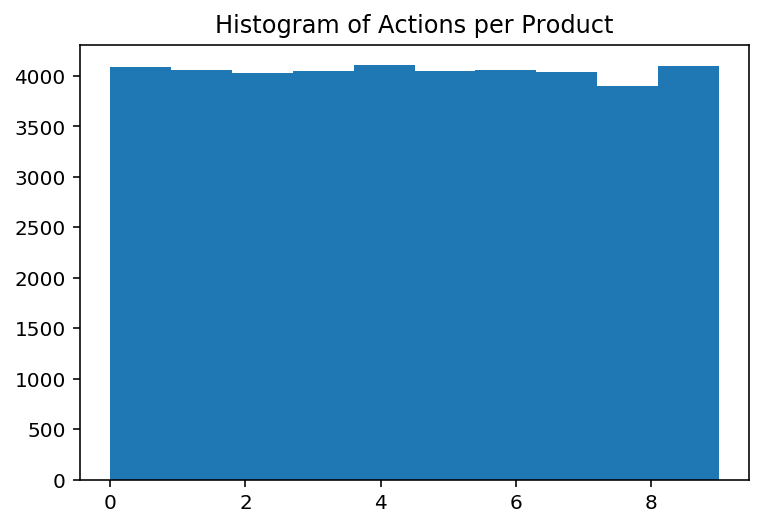

In [5]:
_, ax = plt.subplots()
ax.set_title('Histogram of Actions per Product')

ax.hist(data[data['z'] == 'bandit']['a'])
plt.show()

It is evident that all _`Actions`_ are _*evenly*_ distributed.
That is an expected behaviour because *all* _`Actions`_ are randomly applied for all _Bandit_ _`Events`_.  This is not typical behaviour (usually actions are personalised not random) and we will relax this assumption later in the course.

Clicks:  [49.0, 40.0, 50.0, 43.0, 40.0, 39.0, 32.0, 55.0, 36.0, 40.0]


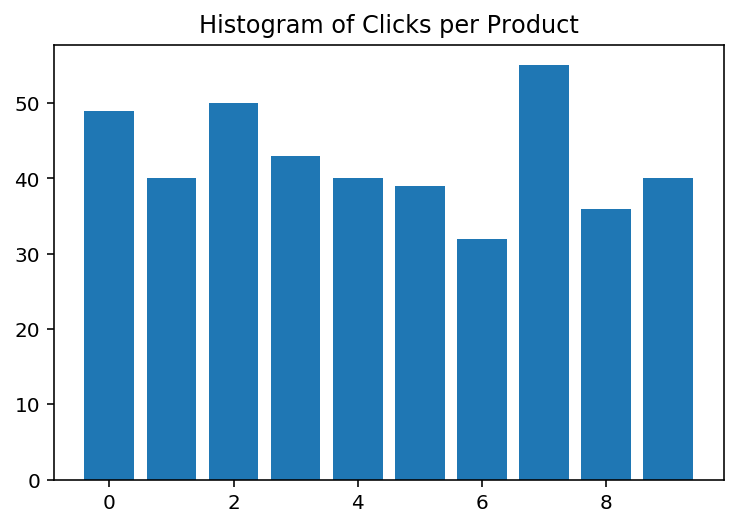

In [6]:
clicks = []
bandits = data[data['z'] == 'bandit']
for product_id in range(NumberOfProducts):
    actions = bandits[bandits['a'] == product_id]
    clicks.append(np.sum(actions[actions['c'] == 1]['c']))
    
print("Clicks: ", clicks)

_, ax = plt.subplots()
ax.set_title('Histogram of Clicks per Product')

ax.bar(range(NumberOfProducts), clicks)
plt.show()

We can estimate a click through rate for each recommendation by dividing the number of times we obtained a click by the number of impressions.  This produces the following "bandit best of":

CTR:  [0.01197166 0.00985222 0.01240695 0.01062778 0.00974659 0.0096225
 0.0078876  0.0136206  0.00924025 0.0097704 ]


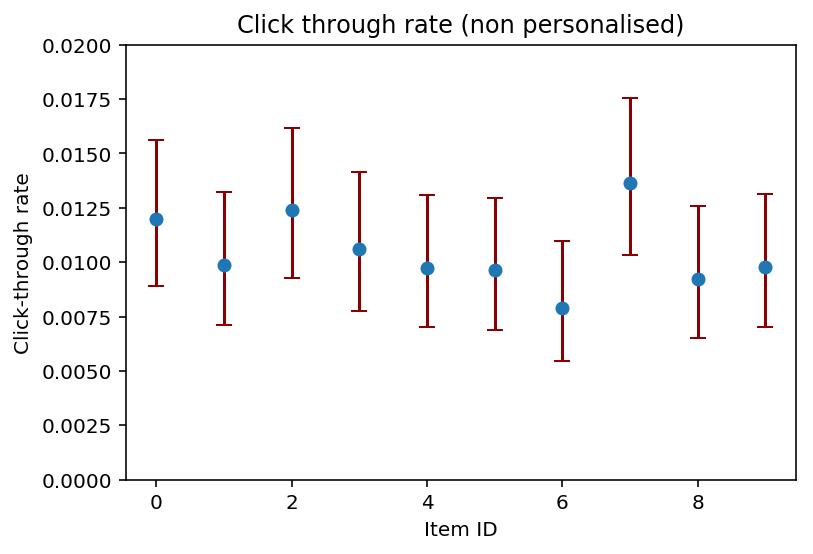

In [7]:
from scipy.stats.distributions import beta

clicks = []
impressions = []
lower_errors = []
upper_errors = []
bandits = data[data['z'] == 'bandit']
for product_id in range(NumberOfProducts):
    actions = bandits[bandits['a'] == product_id]
    clicks.append(np.sum(actions[actions['c'] == 1]['c']))
    impressions.append(sum(actions['a']==product_id))

    # Compute expected value according to a beta distribution
    expected_value = beta.ppf(0.500, clicks[-1] + 1, impressions[-1] - clicks[-1] + 1)
    # Compute a confidence interval
    lower_bound = beta.ppf(0.025, clicks[-1] + 1, impressions[-1] - clicks[-1] + 1)
    upper_bound = beta.ppf(0.975, clicks[-1] + 1, impressions[-1] - clicks[-1] + 1)
    # Save difference as error
    lower_errors.append(expected_value - lower_bound)
    upper_errors.append(upper_bound - expected_value)
    
print("CTR: ", np.array(clicks)/np.array(impressions))

_, ax = plt.subplots()
ax.set_title('Click through rate (non personalised)')

ax.errorbar(range(NumberOfProducts),
            np.array(clicks)/np.array(impressions),
            yerr = (lower_errors, upper_errors),
            fmt = 'o',
            ecolor = 'darkred',
            capsize = 4)

plt.ylim([0,0.02])
plt.xlabel('Item ID')
plt.ylabel('Click-through rate')
plt.savefig('CTR_organiccounter.eps')
plt.show()

The non-personalised click through rate can be uses as a non-personalised agent.  This will be our first likelihood based agent.

FIXME insert bandit best of agent

In [8]:
from collections import defaultdict

from agents.abstract import Agent

class GreedySingleActionAgent(Agent):
    def __init__(self, preferred_action, config = Configuration({'num_products': 10})):
        super(GreedySingleActionAgent, self).__init__(config)
        self.preferred_action = preferred_action
        
    def act(self, observation, reward, done):
        prob = np.zeros(self.config.num_products)
        prob[self.preferred_action] = 1.
        return {
            **super().act(observation, reward, done),
            **{
                'a': self.preferred_action,
                'ps': prob[self.preferred_action],
                'ps-a': prob,
            },
        }

In [9]:
# Initialise bandit
top_ctr_item = np.argmax(np.array(clicks)/np.array(impressions))
print('The Greedy-Bandit agent will always take action {0}'.format(top_ctr_item))
greedy_bandit = GreedySingleActionAgent(top_ctr_item, Configuration(env_1_args))

The Greedy-Bandit agent will always take action 7


The ads that in a non-personalised sense attracts the most clicks is not in general the same as a product that is often viewed organically, to see this we can plot the organic views:

Views:  [1596, 951, 1010, 644, 1270, 621, 1293, 1588, 608, 1303]


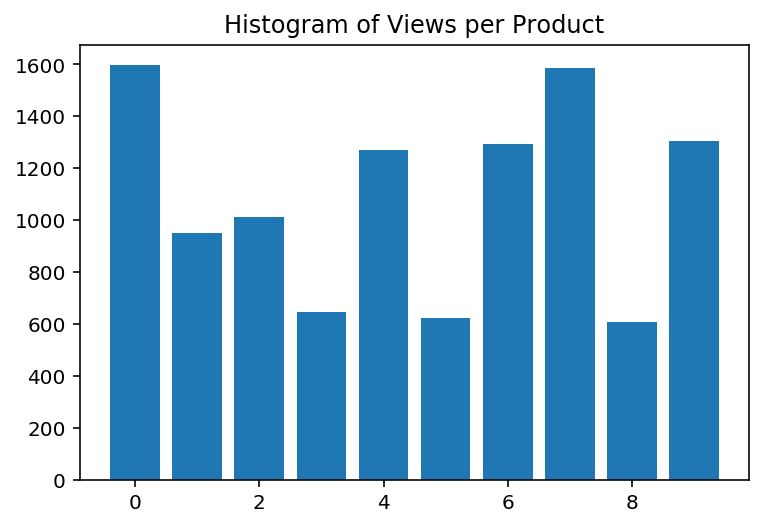

In [10]:
organics = data[data['z'] == 'organic']

views = []
for product_id in range(NumberOfProducts):
    views.append(organics[organics['v'] == product_id].shape[0])

print("Views: ", views)

_, ax = plt.subplots()
ax.set_title('Histogram of Views per Product')

ax.bar(range(NumberOfProducts), views)
plt.show()

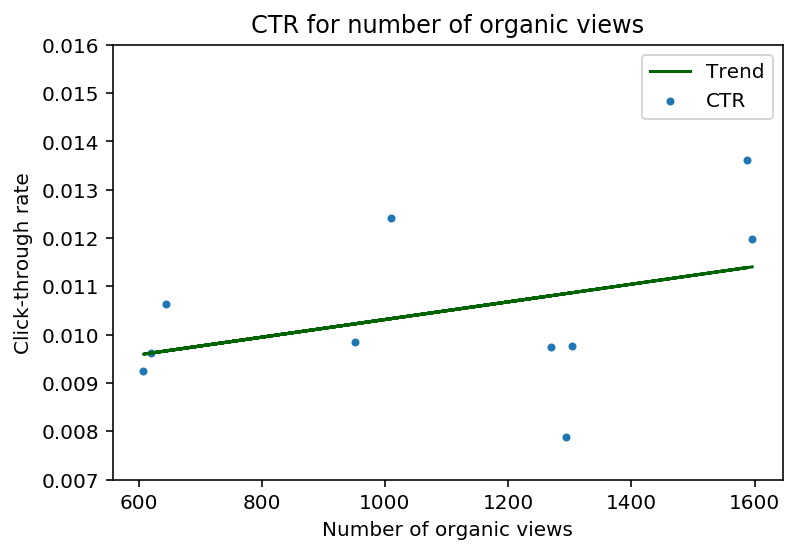

In [11]:
# Plot number of organic views on x-axis and CTR on y-axis
CTR = np.array(clicks)/np.array(impressions)


_, ax = plt.subplots()
ax.set_title('CTR for number of organic views')

ax.scatter(views, CTR, marker = '.', label = 'CTR')

z = np.polyfit(views, CTR, 1)
p = np.poly1d(z)
ax.plot(views, p(views), color = 'darkgreen', label = 'Trend')

plt.xlabel('Number of organic views')
plt.ylabel('Click-through rate')
#plt.xscale('log')
#plt.yscale('log')
plt.gca().set_ylim([0.007,0.016])
plt.legend()
plt.show()

While there may be a relationship between popular products and high click through rate it is certainly not guaranteed.  This fact underlies the need to use bandit feedback.  Here we will develop our final organic agent as an organic best of to latter hammer home this point.

In [12]:
# Initialise bandit
top_viewed_item = np.argmax(views)
print('The organic-best-of agent will always take action {0}'.format(top_viewed_item))
greedy_organic = GreedySingleActionAgent(top_viewed_item, Configuration(env_1_args))

The organic-best-of agent will always take action 0


In [16]:
from datetime import datetime
from reco_gym.evaluate_agent import verify_agents, plot_verify_agents

print('Starting A/B-testing at {0}'.format(datetime.now()))
result = verify_agents(env,
                       50000,
                       {'Greedy-Bandit': greedy_bandit,
                        'Greedy-Organic': greedy_organic})
print('Finished A/B-testing at {0}'.format(datetime.now()))

Starting A/B-testing at 2019-06-12 16:36:46.909196
Finished A/B-testing at 2019-06-12 16:51:18.596835


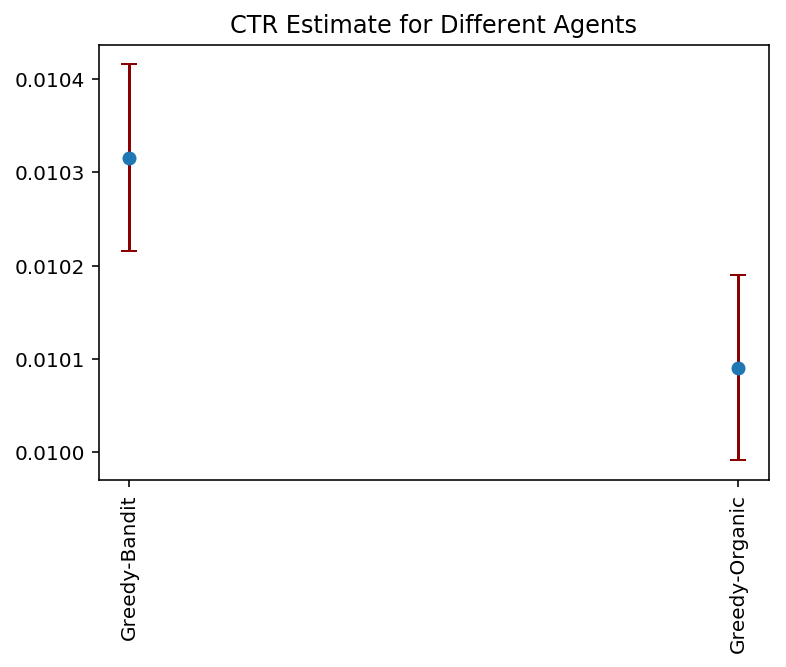

In [17]:
fig = plot_verify_agents(result)
#plt.ylim((.0,.025))
plt.savefig('CTR_estimate_banditVSorganic_5K', dpi = 600, bbox_inches = 'tight')
plt.show()